D'abord on va entrainer un classificateur des images en utilisant le dataset FashionMinst.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



T-shirt/top  Bag  Dress  Sandal


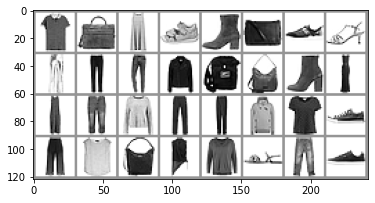

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) #flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
class State:
    def __init__(self, model, optim):
        self.model = model
        self.optimizer = optim
        self.epoch, self.iteration = 0, 0

In [5]:
def train_loop(dataloader, model, optimizer):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        yhat = model(X)
        L = nn.CrossEntropyLoss()
        loss = L(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, pred = torch.max(yhat, 1)
        train_acc += (torch.sum( pred == y) / dataloader.batch_size).item()
    return train_loss / len(dataloader), train_acc / len(dataloader)

In [6]:
def test_loop(dataloader, model):
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            L = nn.CrossEntropyLoss()
            loss = L(yhat, y)
            test_loss += loss.item()
            _, pred = torch.max(yhat, 1)
            test_acc += (torch.sum( pred == y) / dataloader.batch_size).item()
    return test_loss / len(dataloader), test_acc / len(dataloader)

In [7]:
def train(data_train, data_test, save_path, Model, tensorboard_name, iterations=500):
    if save_path.is_file():
        with save_path.open('rb') as fp:
            state = torch.load(fp)
    else :
        model = Model()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        state = State(model, optimizer)
    for epoch in range(state.epoch, iterations):
        loss_train, acc_train = train_loop(data_train, state.model, state.optimizer)
        with save_path.open("wb") as fp:
            state.epoch = epoch + 1
            torch.save(state, fp)
        loss_test, acc_test = test_loop(data_test, state.model)
        writer.add_scalar(tensorboard_name+'/train', loss_train, epoch)
        writer.add_scalar(tensorboard_name+'/test', loss_test, epoch)         
        print('Epoch:', epoch , 'Loss train: ',loss_train, ' Acc train: ', acc_train,'Loss test: ',loss_test, ' Acc test: ', acc_test, '\n\n')
    print("Done!")
    return state.model

In [8]:
from pathlib import Path
import datetime

savepath1 = Path('./model.pt')
writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model1 = train(trainloader, testloader, savepath1, Classifier, "Classifier" ,iterations=100)

Epoch: 0 Loss train:  0.5847104614098867  Acc train:  0.77975 Loss test:  0.4257312097114627  Acc test:  0.8423 


Epoch: 1 Loss train:  0.3802157021979491  Acc train:  0.86075 Loss test:  0.35721042685265564  Acc test:  0.8686 


Epoch: 2 Loss train:  0.32829487603306773  Acc train:  0.8789333333333333 Loss test:  0.33645263743204706  Acc test:  0.8757 


Epoch: 3 Loss train:  0.3014577529609203  Acc train:  0.8901333333333333 Loss test:  0.311737084378901  Acc test:  0.8852 


Epoch: 4 Loss train:  0.27747798210879165  Acc train:  0.8969 Loss test:  0.30305697531161213  Acc test:  0.886 


Epoch: 5 Loss train:  0.2601657152891159  Acc train:  0.9025833333333333 Loss test:  0.31587062356191425  Acc test:  0.8813 


Epoch: 6 Loss train:  0.24741142400304478  Acc train:  0.9074 Loss test:  0.2966152734832627  Acc test:  0.8889 


Epoch: 7 Loss train:  0.23528339067598183  Acc train:  0.9125166666666666 Loss test:  0.3072286778659083  Acc test:  0.8859 


Epoch: 8 Loss train:  0.22483974